In [1]:
import pandas as pd

In [2]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

In [3]:
print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)

sentiment.head()

Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,01-02-2018
1,1517549400,15,Extreme Fear,02-02-2018
2,1517635800,40,Fear,03-02-2018
3,1517722200,24,Extreme Fear,04-02-2018
4,1517808600,11,Extreme Fear,05-02-2018


In [4]:
sentiment.isnull().sum()


timestamp         0
value             0
classification    0
date              0
dtype: int64

In [5]:
trades.isnull().sum()


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [6]:
sentiment['date'] = pd.to_datetime(sentiment['date'], dayfirst=True)

In [7]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)



In [8]:
print(trades['Timestamp IST'].dtype)


datetime64[ns]


In [9]:
trades['Timestamp IST'].isnull().sum()


np.int64(0)

In [10]:
trades['trade_date'] = trades['Timestamp IST'].dt.date


In [11]:
trades['trade_date'] = trades['Timestamp IST'].dt.date



In [12]:
trades[['Timestamp IST', 'trade_date']].head()


,Timestamp IST,trade_date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [13]:
trades['win'] = trades['Closed PnL'].apply(lambda x: 1 if x > 0 else 0)

In [14]:
daily_metrics = trades.groupby('trade_date').agg({
    'Closed PnL': 'sum',
    'Trade ID': 'count',
    'win': 'mean',
    'Size USD': 'mean'
}).reset_index()

In [15]:
daily_metrics.rename(columns={
    'Closed PnL': 'daily_total_pnl',
    'Trade ID': 'daily_trade_count',
    'win': 'win_rate',
    'Size USD': 'avg_trade_size_usd'
}, inplace=True)

daily_metrics.head()

,trade_date,daily_total_pnl,daily_trade_count,win_rate,avg_trade_size_usd
0,2023-05-01,0.000000,3,0.000000,159.000000
1,2023-12-05,0.000000,9,0.000000,5556.203333
2,2023-12-14,-205.434737,11,0.363636,10291.213636
3,2023-12-15,-24.632034,2,0.000000,5304.975000
4,2023-12-16,0.000000,3,0.000000,5116.256667


In [16]:
print(sentiment.columns)


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [17]:
sentiment['date'] = pd.to_datetime(sentiment['date'], dayfirst=True)
sentiment['date_only'] = sentiment['date'].dt.date
print(sentiment.columns)
sentiment.head()


Index(['timestamp', 'value', 'classification', 'date', 'date_only'], dtype='object')


,timestamp,value,classification,date,date_only
0,1517463000,30,Fear,2018-02-01,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02,2018-02-02
2,1517635800,40,Fear,2018-02-03,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05,2018-02-05


In [18]:
merged = daily_metrics.merge(
    sentiment[['date_only', 'classification']],
    left_on='trade_date',
    right_on='date_only',
    how='inner'
)
print("Merged shape:", merged.shape)
merged.head()

Merged shape: (479, 7)


,trade_date,daily_total_pnl,daily_trade_count,win_rate,avg_trade_size_usd,date_only,classification
0,2023-05-01,0.000000,3,0.000000,159.000000,2023-05-01,Greed
1,2023-12-05,0.000000,9,0.000000,5556.203333,2023-12-05,Extreme Greed
2,2023-12-14,-205.434737,11,0.363636,10291.213636,2023-12-14,Greed
3,2023-12-15,-24.632034,2,0.000000,5304.975000,2023-12-15,Greed
4,2023-12-16,0.000000,3,0.000000,5116.256667,2023-12-16,Greed


In [19]:
sentiment_analysis = merged.groupby('classification').agg({
    'daily_total_pnl': 'mean',
    'win_rate': 'mean',
    'daily_trade_count': 'mean',
    'avg_trade_size_usd': 'mean'
}).reset_index()

sentiment_analysis


,classification,daily_total_pnl,win_rate,daily_trade_count,avg_trade_size_usd
0,Extreme Fear,52793.589178,0.327341,1528.571429,4091.804366
1,Extreme Greed,23817.292199,0.467424,350.807018,4410.524482
2,Fear,36891.818040,0.329112,679.527473,6524.294937
3,Greed,11140.566181,0.335986,260.637306,6735.295813
4,Neutral,19297.323516,0.331886,562.477612,7157.527121


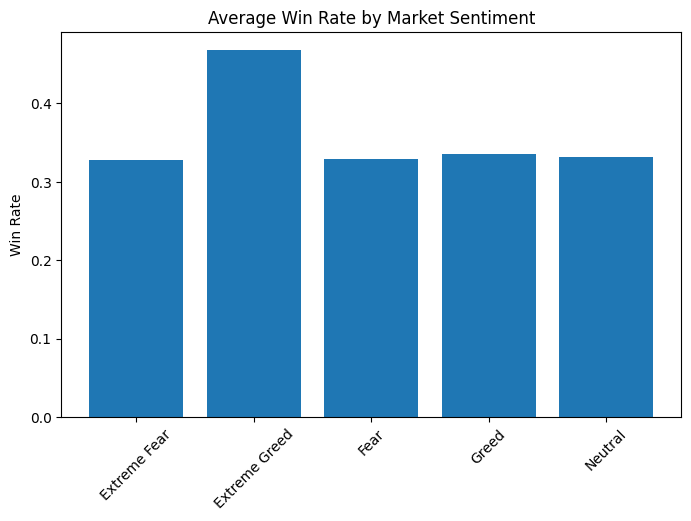

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(sentiment_analysis['classification'], sentiment_analysis['win_rate'])
plt.xticks(rotation=45)
plt.title("Average Win Rate by Market Sentiment")
plt.ylabel("Win Rate")
plt.show()


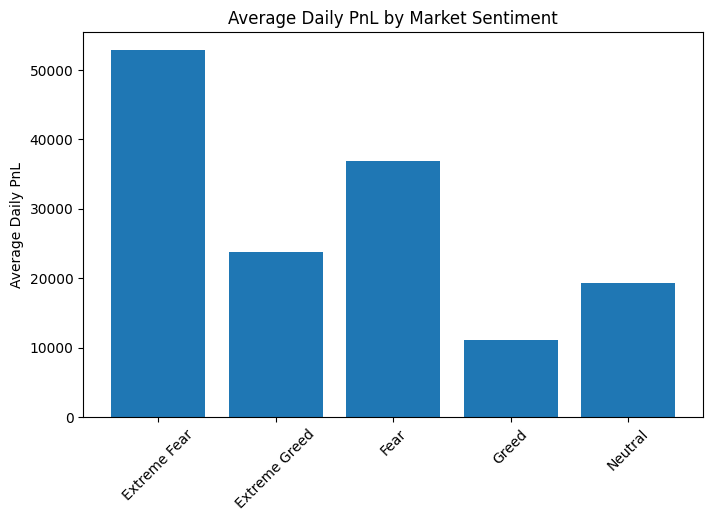

In [21]:
plt.figure(figsize=(8,5))
plt.bar(sentiment_analysis['classification'], sentiment_analysis['daily_total_pnl'])
plt.xticks(rotation=45)
plt.title("Average Daily PnL by Market Sentiment")
plt.ylabel("Average Daily PnL")
plt.show()


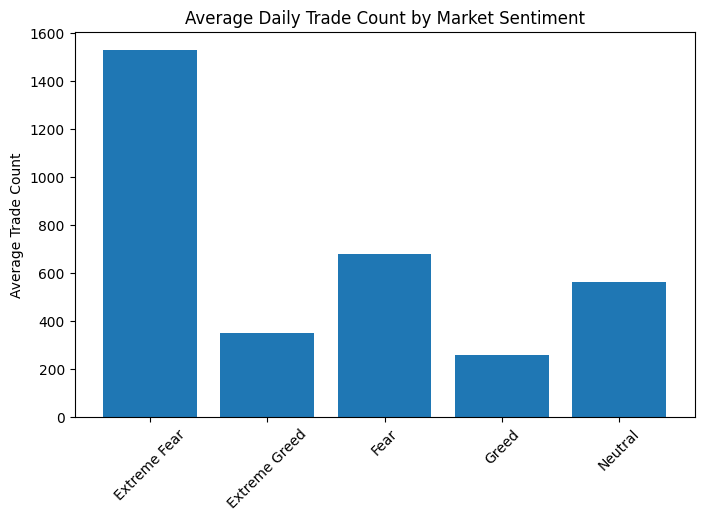

In [22]:
plt.figure(figsize=(8,5))
plt.bar(sentiment_analysis['classification'], sentiment_analysis['daily_trade_count'])
plt.xticks(rotation=45)
plt.title("Average Daily Trade Count by Market Sentiment")
plt.ylabel("Average Trade Count")
plt.show()


In [23]:
trader_summary = trades.groupby('Account').agg({
    'Closed PnL': 'sum',
    'Trade ID': 'count',
    'win': 'mean'
}).reset_index()

trader_summary.rename(columns={
    'Closed PnL': 'total_pnl',
    'Trade ID': 'total_trades',
    'win': 'win_rate'
}, inplace=True)

trader_summary.head()


,Account,total_pnl,total_trades,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,3818,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,7280,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,3809,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,13311,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,3239,0.519914


In [24]:
median_trades = trader_summary['total_trades'].median()

trader_summary['trader_type'] = trader_summary['total_trades'].apply(
    lambda x: 'Frequent' if x > median_trades else 'Infrequent'
)

trader_summary['trader_type'].value_counts()


trader_type
Frequent      16
Infrequent    16
Name: count, dtype: int64

In [25]:
trader_performance = trader_summary.groupby('trader_type').agg({
    'total_pnl': 'mean',
    'win_rate': 'mean',
    'total_trades': 'mean'
}).reset_index()

trader_performance


,trader_type,total_pnl,win_rate,total_trades
0,Frequent,496527.661215,0.413562,11684.8125
1,Infrequent,147032.272750,0.392563,1516.6875


In [26]:
median_win = trader_summary['win_rate'].median()

trader_summary['consistency'] = trader_summary['win_rate'].apply(
    lambda x: 'Consistent' if x > median_win else 'Inconsistent'
)

trader_summary.groupby('consistency').agg({
    'total_pnl': 'mean',
    'total_trades': 'mean'
})


,total_pnl,total_trades
consistency,,
Consistent,296760.268498,7651.6875
Inconsistent,346799.665467,5549.8125


In [27]:
trader_summary.groupby(['trader_type', 'consistency']).agg({
    'total_pnl': 'mean',
    'win_rate': 'mean',
    'total_trades': 'mean'
})


total_pnl  win_rate  total_trades
trader_type consistency                                        
Frequent    Consistent    484543.500969  0.489253     14161.250
            Inconsistent  508511.821460  0.337871      9208.375
Infrequent  Consistent    108977.036027  0.475118      1142.125
            Inconsistent  185087.509473  0.310008      1891.250

In [28]:
print(trades.shape)
print(sentiment.shape)
print(trades.isnull().sum())
print(trades.duplicated().sum())

(211224, 18)
(2644, 5)
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
trade_date          0
win                 0
dtype: int64
0


In [29]:
print(trades.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'trade_date', 'win'],
      dtype='object')


In [30]:
trades['date'] = pd.to_datetime(trades['trade_date']).dt.date


In [31]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
df = trades.merge(sentiment, on='date', how='left')


In [32]:
df.rename(columns={'classification':'sentiment'}, inplace=True)
df['sentiment'].value_counts()


sentiment
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

In [33]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date


In [34]:
df = df.loc[:,~df.columns.duplicated()]


In [35]:
df['sentiment_binary'] = df['sentiment'].replace({
    'Extreme Fear':'Fear',
    'Extreme Greed':'Greed'
})


In [36]:
df['sentiment_binary'].value_counts()


sentiment_binary
Greed      90295
Fear       83237
Neutral    37686
Name: count, dtype: int64

In [37]:
df.groupby('sentiment_binary')['Closed PnL'].agg(['mean','median','count'])


,mean,median,count
sentiment_binary,,,
Fear,49.212077,0.0,83237
Greed,53.882281,0.0,90295
Neutral,34.307718,0.0,37686


In [38]:
df.groupby('sentiment_binary')['win'].mean()


sentiment_binary
Fear       0.407871
Greed      0.420311
Neutral    0.396991
Name: win, dtype: float64

In [39]:
df.groupby('sentiment_binary').size()


sentiment_binary
Fear       83237
Greed      90295
Neutral    37686
dtype: int64

In [40]:
df.groupby('sentiment_binary')['Size USD'].mean()


sentiment_binary
Fear       7182.011019
Greed      4574.424490
Neutral    4782.732661
Name: Size USD, dtype: float64

In [41]:
df.groupby('sentiment_binary')['Closed PnL'].agg(['mean','count'])



,mean,count
sentiment_binary,,
Fear,49.212077,83237
Greed,53.882281,90295
Neutral,34.307718,37686


In [42]:
df.groupby('sentiment_binary')['Size USD'].mean()
df.groupby('sentiment_binary')['win'].mean()
df.groupby('sentiment_binary').size()

sentiment_binary
Fear       83237
Greed      90295
Neutral    37686
dtype: int64

In [43]:
df.groupby('sentiment_binary')['Size USD'].mean()


sentiment_binary
Fear       7182.011019
Greed      4574.424490
Neutral    4782.732661
Name: Size USD, dtype: float64

In [44]:
df.groupby('sentiment_binary')['win'].mean()


sentiment_binary
Fear       0.407871
Greed      0.420311
Neutral    0.396991
Name: win, dtype: float64

In [45]:
daily_pnl = df.groupby(['Account','date'])['Closed PnL'].sum().reset_index()


In [46]:
trades_per_day = df.groupby(['Account','date']).size().reset_index(name='num_trades')



In [47]:

df.groupby(['Account','Side']).size().unstack().fillna(0)


Side,BUY,SELL
Account,,
0x083384f897ee0f19899168e3b1bec365f52a9012,1711,2107
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3055,4225
0x271b280974205ca63b716753467d5a371de622ab,1566,2243
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,6699,6612
0x2c229d22b100a7beb69122eed721cee9b24011dd,1179,2060
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,182,633
0x39cef799f8b69da1995852eea189df24eb5cae3c,1648,1941
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,170,162
0x420ab45e0bd8863569a5efbb9c05d91f40624641,101,282


In [48]:

df['size_bucket'] = pd.qcut(df['Size USD'], 2, labels=['Low','High'])


In [49]:
df['size_bucket'] = pd.qcut(df['Size USD'], 2, labels=['Low','High'])
df.groupby('size_bucket')['Closed PnL'].mean()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15588\4283171021.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('size_bucket')['Closed PnL'].mean()


size_bucket
Low      4.381445
High    93.116556
Name: Closed PnL, dtype: float64

In [50]:
df.groupby(['size_bucket','sentiment_binary'])['Closed PnL'].mean()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15588\144179400.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['size_bucket','sentiment_binary'])['Closed PnL'].mean()


size_bucket  sentiment_binary
Low          Fear                  2.971356
             Greed                 6.387068
             Neutral               2.188668
High         Fear                 87.647166
             Greed               108.033872
             Neutral              69.581271
Name: Closed PnL, dtype: float64

In [51]:
df_sorted = df.sort_values('date')
df_sorted['cum_pnl'] = df_sorted.groupby('size_bucket')['Closed PnL'].cumsum()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15588\331886180.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sorted['cum_pnl'] = df_sorted.groupby('size_bucket')['Closed PnL'].cumsum()


In [52]:
df.groupby('size_bucket')['Closed PnL'].std()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15588\3589025503.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('size_bucket')['Closed PnL'].std()


size_bucket
Low       33.078125
High    1297.961788
Name: Closed PnL, dtype: float64

In [53]:
df['profit_flag'] = (df['Closed PnL'] > 0).astype(int)

features = ['Size USD','win']
X = df[features]
y = df['profit_flag']


In [54]:
df['profit_flag']


0         0
1         0
2         0
3         0
4         0
         ..
211219    0
211220    0
211221    0
211222    0
211223    0
Name: profit_flag, Length: 211224, dtype: int64